In [20]:
import typing
import itertools

import numpy
import pandas 

import scipy
import statsmodels
import statsmodels.stats
import statsmodels.stats.descriptivestats

import seaborn

import llm_questionnaires as llmq

In [21]:
MODELS: typing.List[str] = llmq.CONSTANTS.MODELS[::2]
MODELS

['llama3.1-8b', 'mistral-7b', 'qwen2.5-7b']

In [22]:
COLUMNS: typing.List[str] = [str(col[1]) + str(col[0]) for col in itertools.product(range(1, 11), "ENACO")]

In [23]:
raw: typing.Dict[str, pandas.DataFrame]= {
    **llmq.evaluation.read_populations("data/base", MODELS, COLUMNS),
    "human_full": (
        pandas.read_csv("../../../data/big_5/survey.csv")
        .rename_axis(index="participant")
        .filter(regex='E|N|C|A|O', axis=1)
        .replace(-1, None)
        .apply(pandas.to_numeric)
    ),
    "random": (
        pandas.DataFrame(numpy.random.randint(0,5, (1000, 50)), columns=COLUMNS)
        .rename_axis(index="participant")
    )
}

raw.keys()

dict_keys(['llama3.1-8b', 'mistral-7b', 'qwen2.5-7b', 'human_full', 'random'])

In [25]:
for key, values in raw.items():
    values.to_csv(f"reports/raw.{key}.csv", index=False)

In [26]:
descriptive = pandas.concat({
    key: statsmodels.stats.descriptivestats.describe(values).T
    for key, values in raw.items()
})
descriptive

nobs  missing      mean   std_err  upper_ci  lower_ci  \
llama3.1-8b E1    912.0      6.0  3.394040  0.037748  3.468024  3.320055   
            N1    912.0     33.0  3.634812  0.041509  3.716169  3.553455   
            A1    912.0     33.0  3.708760  0.031411  3.770324  3.647196   
            C1    912.0     53.0  3.251455  0.028142  3.306612  3.196299   
            O1    912.0    102.0  3.196296  0.056310  3.306661  3.085931   
...                 ...      ...       ...       ...       ...       ...   
random      E10  1000.0      0.0  2.047000  0.045988  2.137135  1.956865   
            N10  1000.0      0.0  2.057000  0.044336  2.143898  1.970102   
            A10  1000.0      0.0  2.076000  0.044701  2.163613  1.988387   
            C10  1000.0      0.0  2.007000  0.046033  2.097224  1.916776   
            O10  1000.0      0.0  2.022000  0.044356  2.108937  1.935063   

                      std  iqr  iqr_normal       mad  ...  median   1%   5%  \
llama3.1-8b E1   1.136209  2.0    1.482602  0.989591  ...     4.0  1.0  2.0   
            N1   1.230670  2.0    1.482602  1.047102  ...     4.0  1.0  1.0   
            A1   0.931261  1.0    0.741301  0.777756  ...     4.0  1.0  2.0   
            C1   0.824795  1.0    0.741301  0.613188  ...     3.0  1.0  2.0   
            O1   1.602605  3.0    2.223903  1.479278  ...     4.0  1.0  1.0   
...                   ...  ...         ...       ...  ...     ...  ...  ...   
random      E10  1.454272  2.0    1.482602  1.258614  ...     2.0  0.0  0.0   
            N10  1.402040  2.0    1.482602  1.188690  ...     2.0  0.0  0.0   
            A10  1.413585  2.0    1.482602  1.218312  ...     2.0  0.0  0.0   
            C10  1.455703  2.0    1.482602  1.254218  ...     2.0  0.0  0.0   
            O10  1.402670  2.0    1.482602  1.198224  ...     2.0  0.0  0.0   

                 10%  25%  50%  75%  90%  95%  99%  
llama3.1-8b E1   2.0  2.0  4.0  4.0  5.0  5.0  5.0  
            N1   2.0  3.0  4.0  5.0  5.0  5.0  5.0  
            A1   3.0  3.0  4.0  4.0  5.0  5.0  5.0  
            C1   3.0  3.0  3.0  4.0  4.0  5.0  5.0  
            O1   1.0  2.0  4.0  5.0  5.0  5.0  5.0  
...              ...  ...  ...  ...  ...  ...  ...  
random      E10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            N10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            A10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            C10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            O10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  

[250 rows x 31 columns]

In [27]:
raw["human_sampled"] = (
    pandas.DataFrame(numpy.stack([
        numpy.random.normal(row["mean"], row["std"], 1000).astype(int)
        for _, row in descriptive.loc["human_full"][["mean", "std"]].iterrows()
    ], axis=1), columns=COLUMNS)
    .rename_axis(index="participant")
)

In [28]:
pandas.concat({
    (key_1, key_2): (
        pandas.Series(
            scipy
            .stats.f_oneway(
                values_1,
                values_2,
                nan_policy="omit"
            )
            .pvalue
            > 0.05,
            name="f_oneway_significant"
        )
        .value_counts()
    )
    for key_1, values_1 in raw.items()
    for key_2, values_2 in raw.items()
}).to_frame()

count
                            f_oneway_significant       
llama3.1-8b   llama3.1-8b   True                     37
                            False                    13
              mistral-7b    False                    30
                            True                     20
              qwen2.5-7b    False                    45
...                                                 ...
human_sampled qwen2.5-7b    False                    50
              human_full    False                    50
              random        False                    46
                            True                      4
              human_sampled True                     50

[64 rows x 1 columns]

In [29]:
sim = (
    llmq.evaluation.apply_calc_similarity(raw)
    .to_frame()
    .reset_index(level=[0, 1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    .reindex(
        columns=(idx := ["random", "human_sampled", "human_full", *MODELS]),
        index=idx
    )
    .pipe(llmq.evaluation.extract_triu_df)
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))

\begin{tabular}{lrrrrrr}
\toprule
level_1 & \rotatebox{65}{random} & \rotatebox{65}{human\_sampled} & \rotatebox{65}{human\_full} & \rotatebox{65}{llama3.1-8b} & \rotatebox{65}{mistral-7b} & \rotatebox{65}{qwen2.5-7b} \\
level_0 &  &  &  &  &  &  \\
\midrule
random &  &  &  &  &  &  \\
human\_sampled & 0.054 &  &  &  &  &  \\
human\_full & -0.040 & 0.007 &  &  &  &  \\
llama3.1-8b & 0.006 & -0.012 & 0.000 &  &  &  \\
mistral-7b & 0.005 & -0.008 & -0.010 & -0.039 &  &  \\
qwen2.5-7b & 0.003 & -0.019 & 0.032 & 0.026 & -0.040 &  \\
\bottomrule
\end{tabular}



<Axes: xlabel='level_1', ylabel='level_0'>

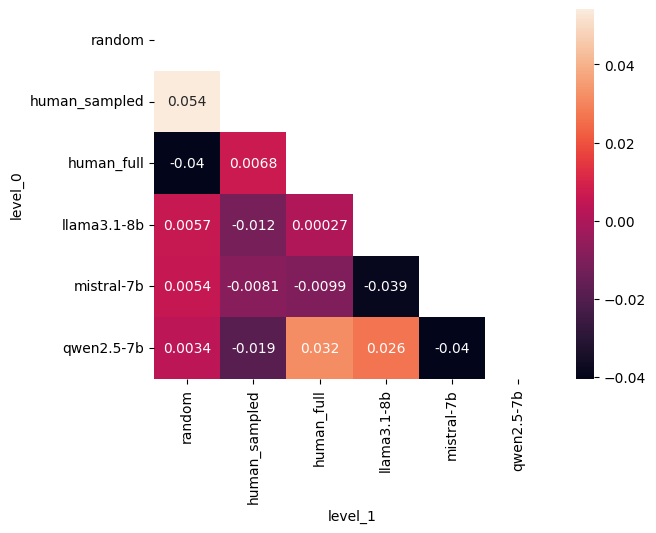

In [30]:
seaborn.heatmap(sim, annot=True, mask=numpy.triu(sim))

In [ ]:
human_chunked = {
    f"{n:02d}": chunk
    for n, chunk in enumerate(numpy.array_split(raw["human_full"].sample(frac=1.0), 100), start=1)
}

sim = (
    llmq.evaluation.apply_calc_similarity(human_chunked)
    .to_frame()
    .reset_index(level=[0,1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    #
    .where(lambda df: pandas.DataFrame(
        [[i > j for j in range(len(df.columns))] for i in range(len(df.index))],
        index=df.index,
        columns=df.columns
    ))
    
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))
print({
    "mean": sim.stack().mean(),
    "std": sim.stack().std()
})

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


<Axes: xlabel='level_1', ylabel='level_0'>

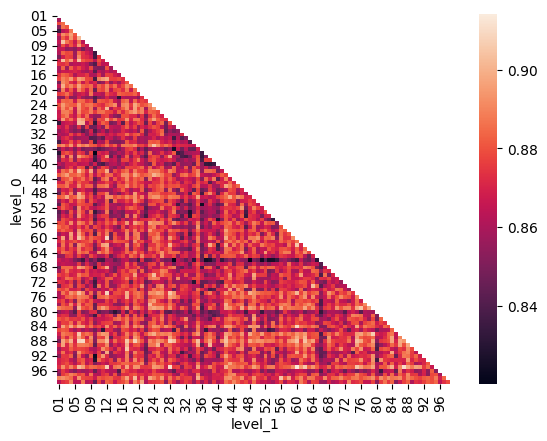

In [ ]:
seaborn.heatmap(sim, annot=False, mask=numpy.triu(sim))